## Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re


In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Id for FAANG binary file
id = '1-4wGVlhCObAoAM_DOLL3D4YsJhOb1ZSj'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Combined_FAANG_binary_previous.csv')
df = pd.read_csv('Combined_FAANG_binary_previous.csv')
df = df[df['message'].notna()]


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
# FAANG percentage change file 
df = pd.read_csv('/content/drive/MyDrive/Capstone/Combined_FAANG_percentage_2.2.csv')

In [ ]:
# Change the year as per the requirement
# Currently only 1 year of data is loaded, i.e. from 2019
df.drop(df[df['Date'] <= '2019-07-20'].index, inplace = True) 
df

,symbol,message,datetime,user,message_id,Date,Time,label
0,AAPL,peak profit last 6 expired option alerts aapl ...,2020-07-19 09:49:35,1442893,229008387,2020-07-19,09:49:35,1
1,AAPL,aapl jul 17 382 50 calls option volume 144 44 ...,2020-07-19 09:47:26,1442893,229008357,2020-07-19,09:47:26,1
2,AAPL,tsla market true bubble territory profitable c...,2020-07-19 09:01:25,1115913,229007569,2020-07-19,09:01:25,1
3,AAPL,aapl analyzed 26 analysts buy consensus 86 ana...,2020-07-19 08:13:00,47688,229006733,2020-07-19,08:13:00,1
4,AAPL,aapl new article dogs dow august 4 adopt ignore,2020-07-19 07:54:05,1555408,229006403,2020-07-19,07:54:05,1
...,...,...,...,...,...,...,...,...
2135898,NFLX,nflx lot 360 p 365 c exp,2018-07-21 00:21:00,1527360,130910498,2018-07-21,00:21:00,0
2135899,NFLX,nflx geez one day folks bullish next day beari...,2018-07-21 00:20:35,1457996,130910477,2018-07-21,00:20:35,0
2135900,NFLX,iq 50 million subscribers nflx little 100 mill...,2018-07-21 00:17:15,1543466,130910281,2018-07-21,00:17:15,0
2135901,NFLX,bac fb nxpi ge aapl nflx msft chk fb sn mu pvg...,2018-07-21 00:11:31,917666,130909960,2018-07-21,00:11:31,0


In [ ]:
df

,symbol,message,datetime,user,message_id,Date,Time,label
0,AAPL,peak profit last 6 expired option alerts aapl ...,2020-07-19 09:49:35,1442893,229008387,2020-07-19,09:49:35,1
1,AAPL,aapl jul 17 382 50 calls option volume 144 44 ...,2020-07-19 09:47:26,1442893,229008357,2020-07-19,09:47:26,1
2,AAPL,tsla market true bubble territory profitable c...,2020-07-19 09:01:25,1115913,229007569,2020-07-19,09:01:25,1
3,AAPL,aapl analyzed 26 analysts buy consensus 86 ana...,2020-07-19 08:13:00,47688,229006733,2020-07-19,08:13:00,1
4,AAPL,aapl new article dogs dow august 4 adopt ignore,2020-07-19 07:54:05,1555408,229006403,2020-07-19,07:54:05,1
...,...,...,...,...,...,...,...,...
2135898,NFLX,nflx lot 360 p 365 c exp,2018-07-21 00:21:00,1527360,130910498,2018-07-21,00:21:00,0
2135899,NFLX,nflx geez one day folks bullish next day beari...,2018-07-21 00:20:35,1457996,130910477,2018-07-21,00:20:35,0
2135900,NFLX,iq 50 million subscribers nflx little 100 mill...,2018-07-21 00:17:15,1543466,130910281,2018-07-21,00:17:15,0
2135901,NFLX,bac fb nxpi ge aapl nflx msft chk fb sn mu pvg...,2018-07-21 00:11:31,917666,130909960,2018-07-21,00:11:31,0


In [ ]:
df["label"].value_counts()

 1    451745
-1    371365
 0    198307
Name: label, dtype: int64

In [ ]:
# Drop the Neutral values
df.drop(df[df['label'] == 0].index, inplace = True) 
df['label'].value_counts()

 1    451745
-1    371365
Name: label, dtype: int64

In [ ]:
# Replace the -1 to 0 for easier training 
df["label"].replace({-1: 0}, inplace=True) # therefore, 0 - negative, 1 - positive

In [ ]:
df = df.sample(frac=1)

##Train and predict

In [ ]:
# Data is split to 90:10 ratio, i.e. 90% data for training and 10% for testing 
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.10, random_state=42)

In [ ]:
x_train

1745678                          dis earnings tomorrow close
274440     baba aapl crm v anyone know employee stock opt...
1388104                   amzn nice run today need hold 1650
2071795     nflx 100 weeks changed back extreme insanity one
335374     aapl falls lower go 120 quickly gets back 140 ...
                                 ...                        
187018     aapl put ur kids sleep shorty otherwise tim co...
291231     apple unveils subscription video news gaming s...
1932706    nflx netflix open 450 tomorrow hype priced er ...
1296458                    amzn always sell fridays watching
1816503    googl goog hot garbage lot like android lol go...
Name: message, Length: 740799, dtype: object

In [ ]:
y_test.value_counts()

1    28395
0    23041
Name: label, dtype: int64

In [ ]:
# Definin the GridSearch parameters for pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', GradientBoostingRegressor())])
tuned_parameters = {
    'clf__learning_rate': [0.025],
    'clf__max_depth' : [5],
    'clf__n_estimators':[50]
}

In [ ]:
# Get the parameters keys to be used in pipeline
text_clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'clf__alpha', 'clf__ccp_alpha', 'clf__criterion', 'clf__init', 'clf__learning_rate', 'clf__loss', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_iter_no_change', 'clf__presort', 'clf__random_state', 'clf__subsample', 'clf__tol', 'clf__validation_fraction', 'clf__verbose', 'clf__warm_start'])

In [ ]:
# Train the model
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=5)
clf.fit(x_train, y_train)

# Predict and generate the classification report
print(classification_report(y_test, (clf.predict(x_test).round()), digits=4))

              precision    recall  f1-score   support

           0     0.6132    0.0237    0.0457     37077
           1     0.5524    0.9877    0.7086     45234

    accuracy                         0.5535     82311
   macro avg     0.5828    0.5057    0.3771     82311
weighted avg     0.5798    0.5535    0.4100     82311



In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                           learning_rate=0.025, loss='ls',
                                           max_depth=5, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impur

In [ ]:
# Save the vectors
count_vect = text_clf['vect']

In [ ]:
import pickle

#Save Vectorizer
vec_file = '/content/drive/My Drive/Capstone/traditionalML/GadeintBooster_2label_vectorizerv1.pickle'
pickle.dump(count_vect, open(vec_file, 'wb'))

# Save the model
with open('/content/drive/My Drive/Capstone/traditionalML/GradientBooster_2labelv1.model', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
predicted_forest = clf.predict(x_test)

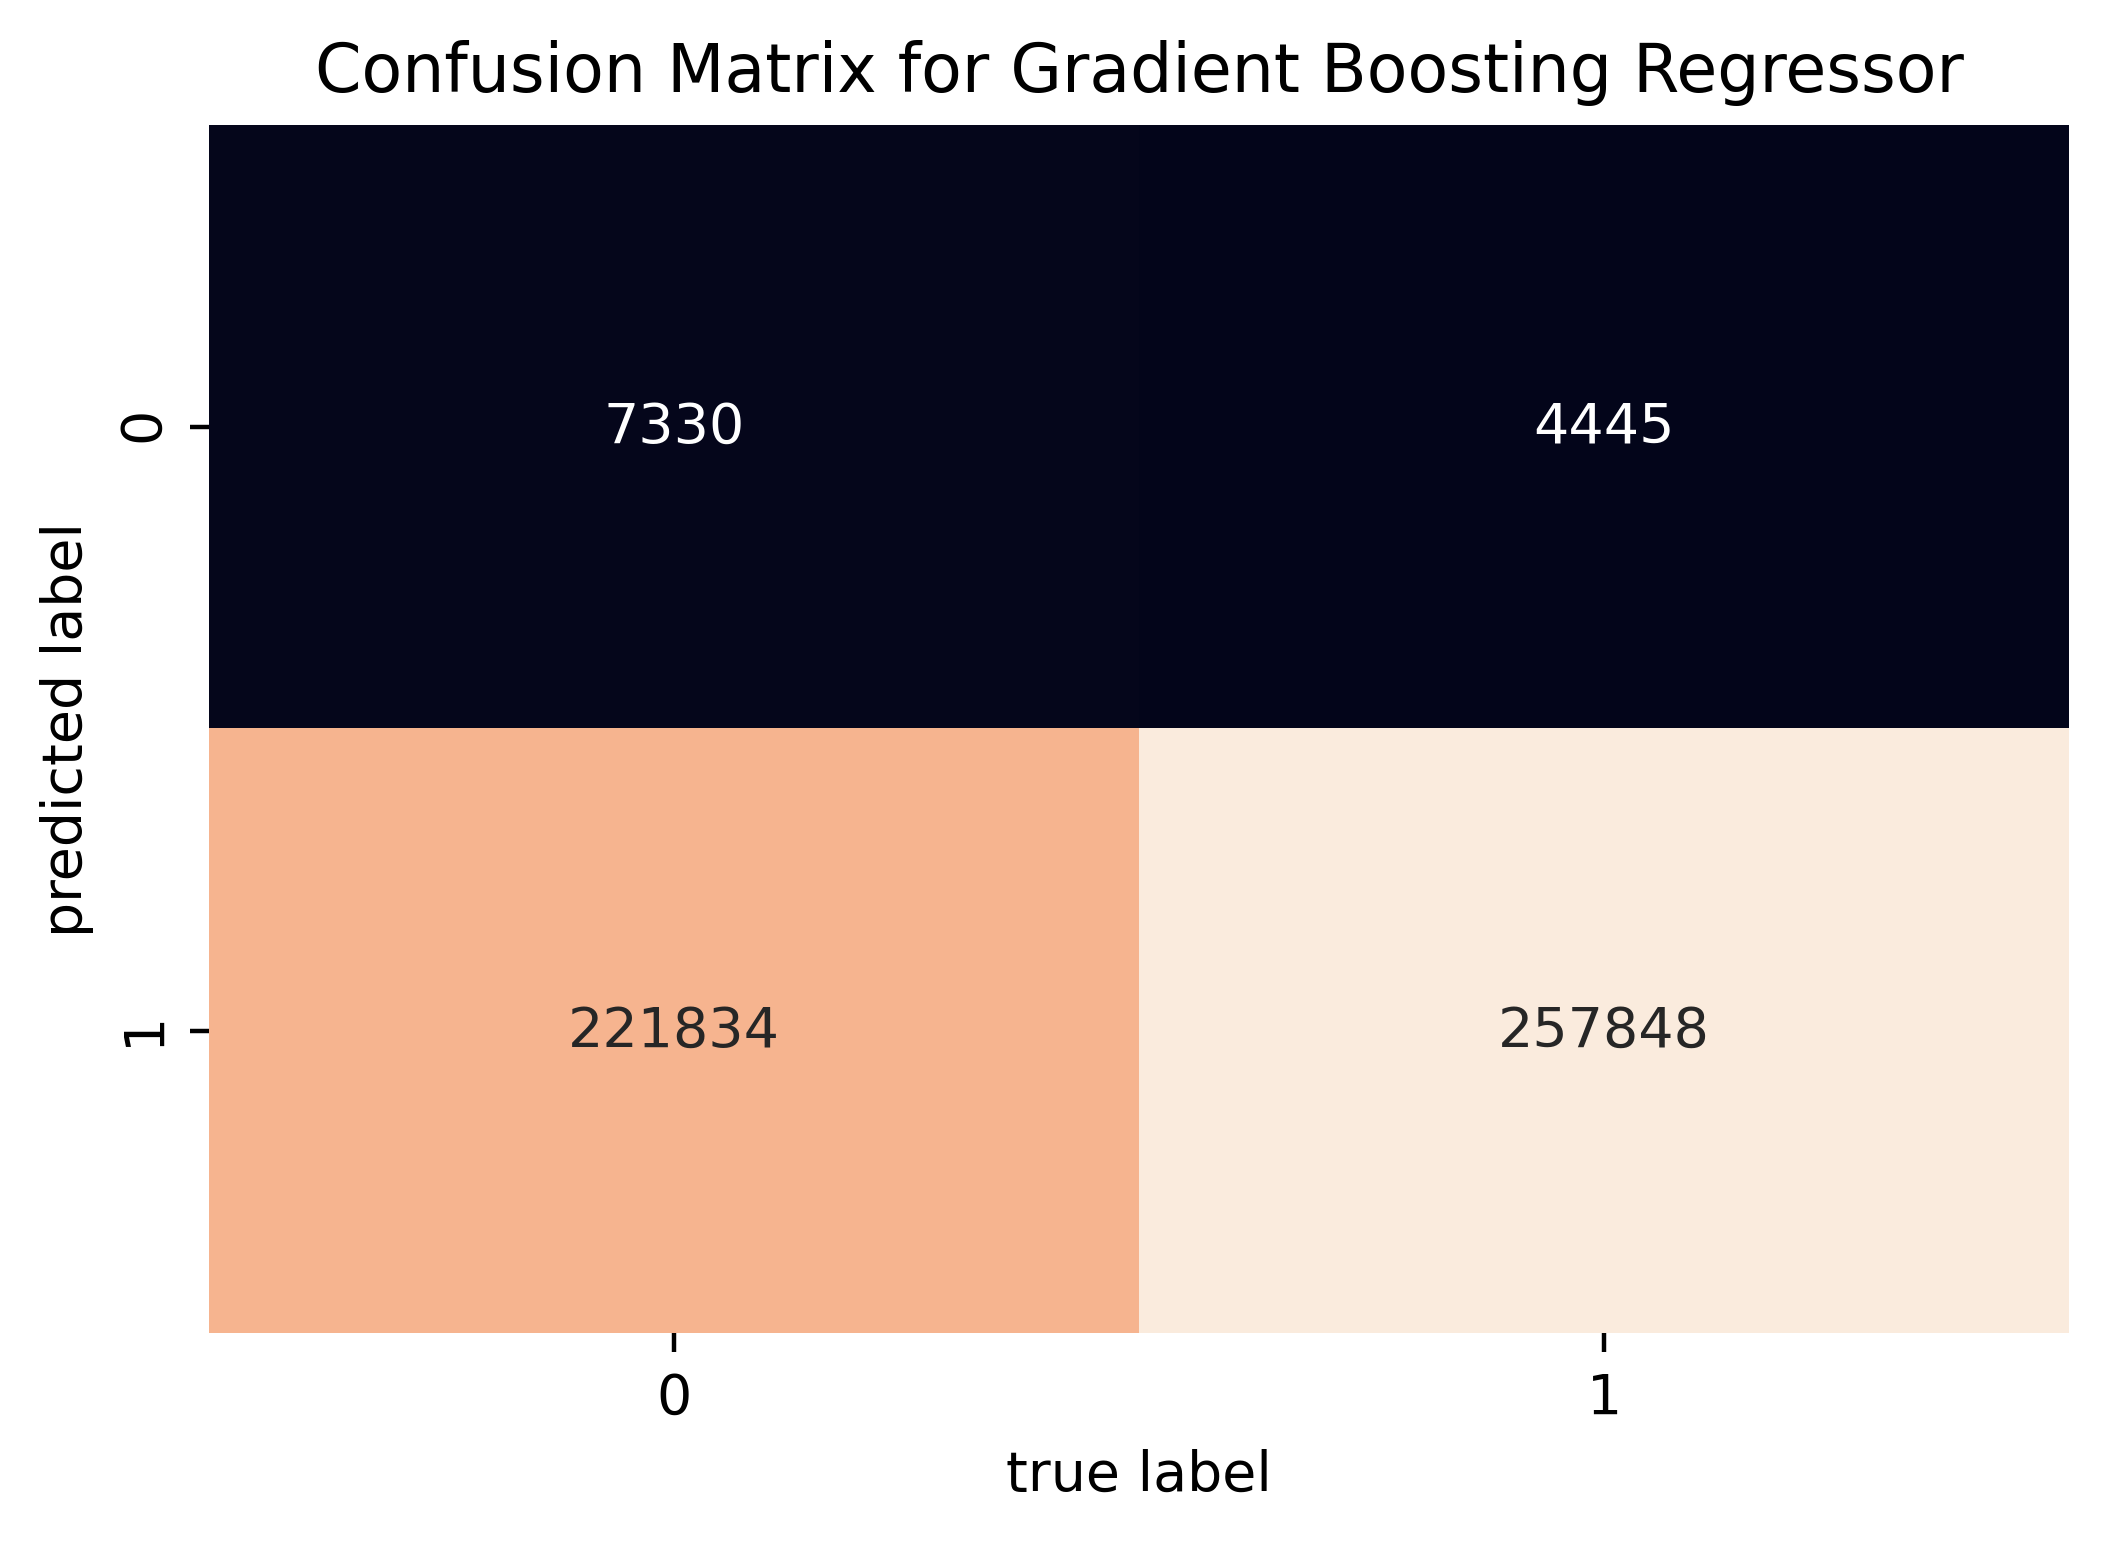

In [ ]:
# Plot the confusion matrix for Gradient boosting regressor
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(dpi=400)
mat = confusion_matrix(y_test, predicted_forest.round())
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Gradient Boosting Regressor')
plt.xlabel('true label')
plt.ylabel('predicted label')
# plt.savefig("assets/confusion_matrix.png")
plt.show()